# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold


In [3]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [220]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00,14980.00
mean,4321.92,4009.77,4264.02,4164.95,4341.74,4644.02,4110.40,4616.06,4218.83,4231.32,4202.46,4279.23,4615.21,4416.44,0.45
std,2492.07,45.94,44.43,5216.40,34.74,2924.79,4600.93,29.29,2136.41,38.05,37.79,41.54,1208.37,5891.29,0.50
min,1030.77,2830.77,1040.00,2453.33,2089.74,2768.21,2086.15,4567.18,1357.95,1816.41,3273.33,2257.95,86.67,1366.15,0.00
25%,4280.51,3990.77,4250.26,4108.21,4331.79,4611.79,4057.95,4604.62,4190.77,4220.51,4190.26,4267.69,4590.77,4342.05,0.00
50%,4294.36,4005.64,4262.56,4120.51,4338.97,4617.95,4070.26,4613.33,4199.49,4229.23,4200.51,4276.92,4603.08,4354.87,0.00
75%,4311.79,4023.08,4270.77,4132.31,4347.18,4626.67,4083.59,4624.10,4209.23,4239.49,4211.28,4287.18,4617.44,4372.82,1.00
max,309231.00,7804.62,6880.51,642564.00,6474.36,362564.00,567179.00,7264.10,265641.00,6674.36,6823.08,7002.56,152308.00,715897.00,1.00


In [221]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

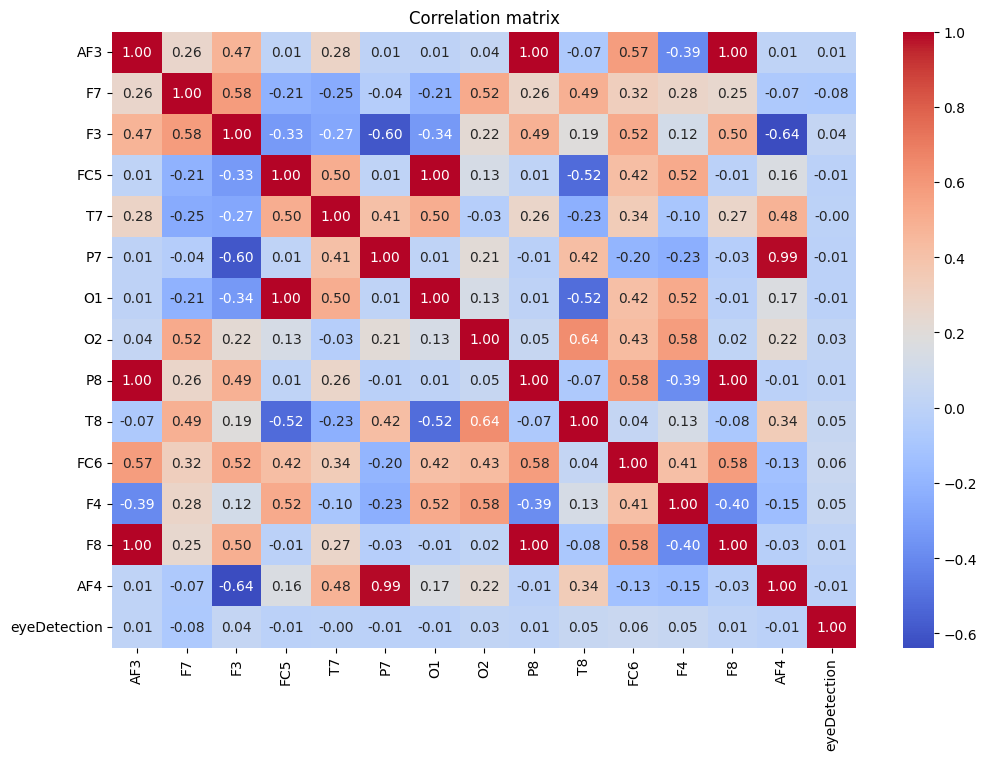

In [222]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), P8 i F8(1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [4]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [224]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [225]:
df.duplicated().any()

np.False_

In [226]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

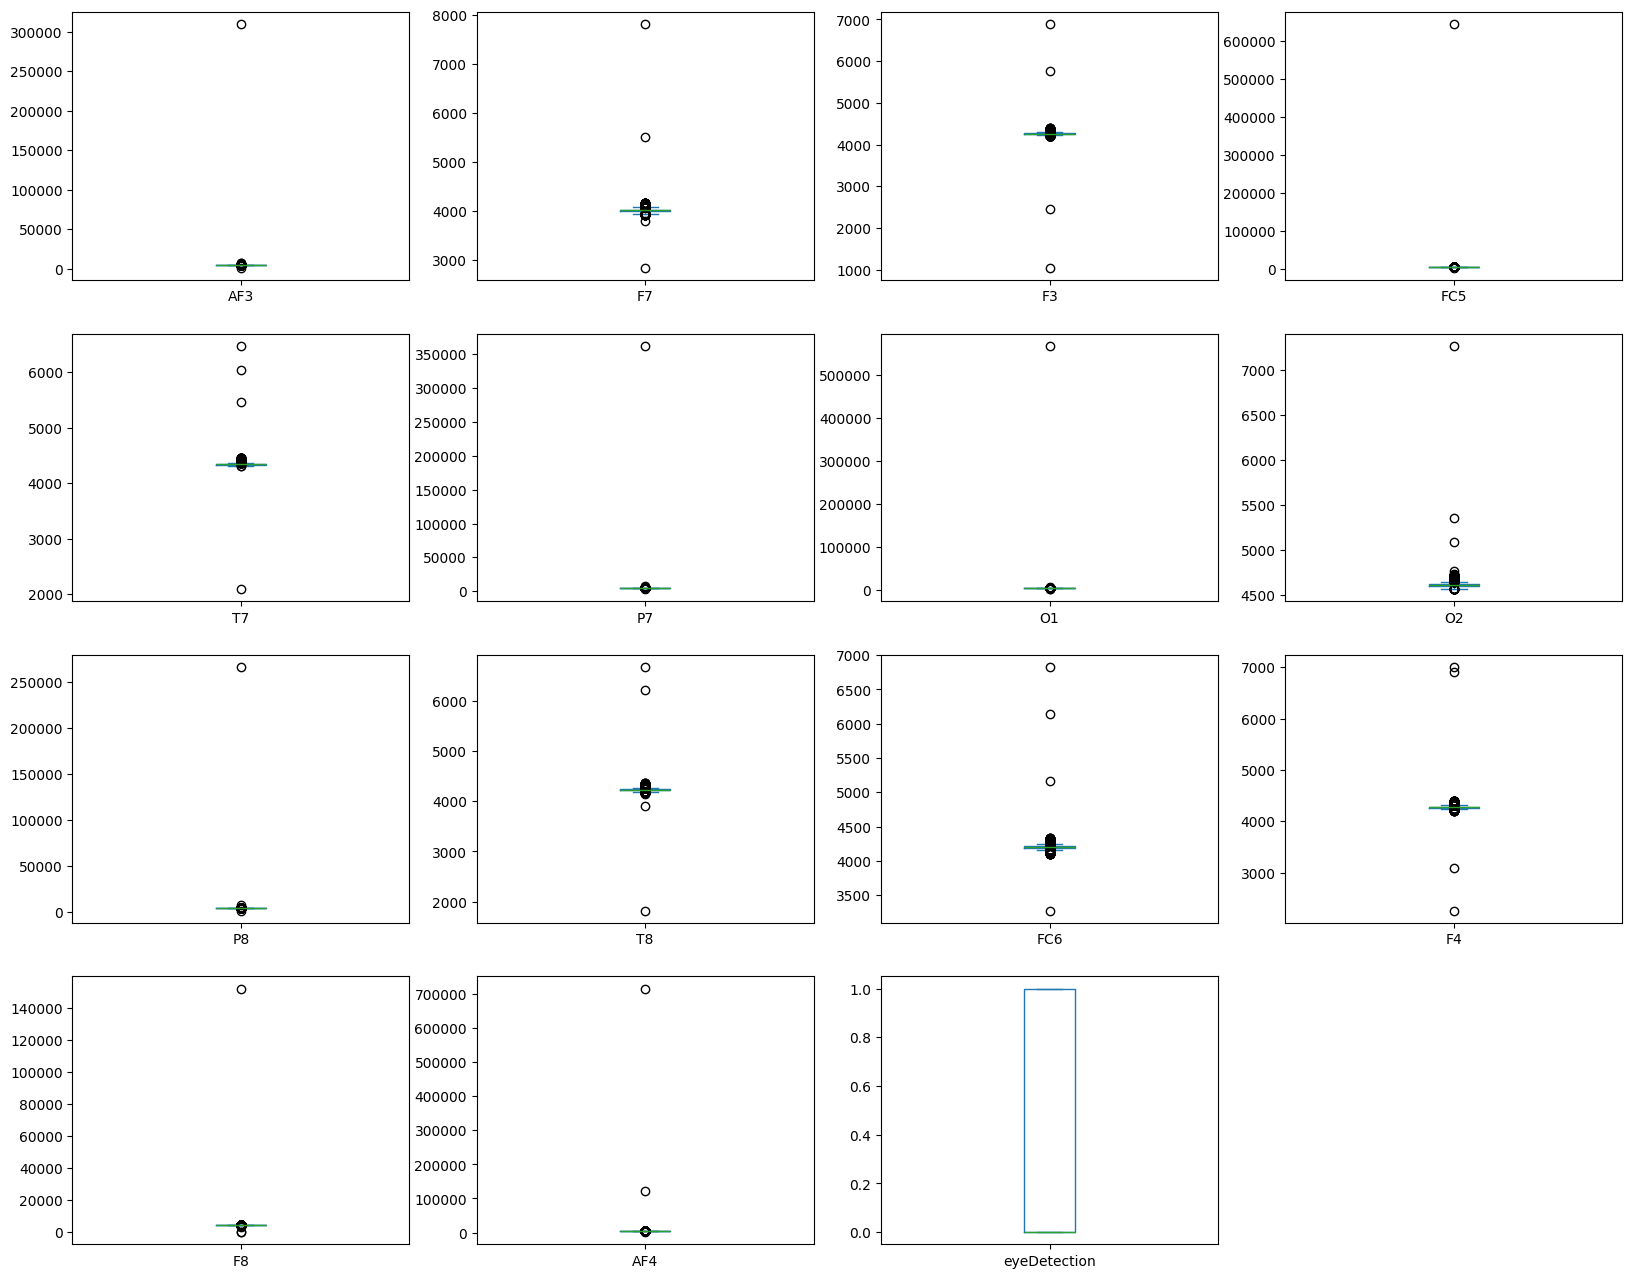

In [5]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

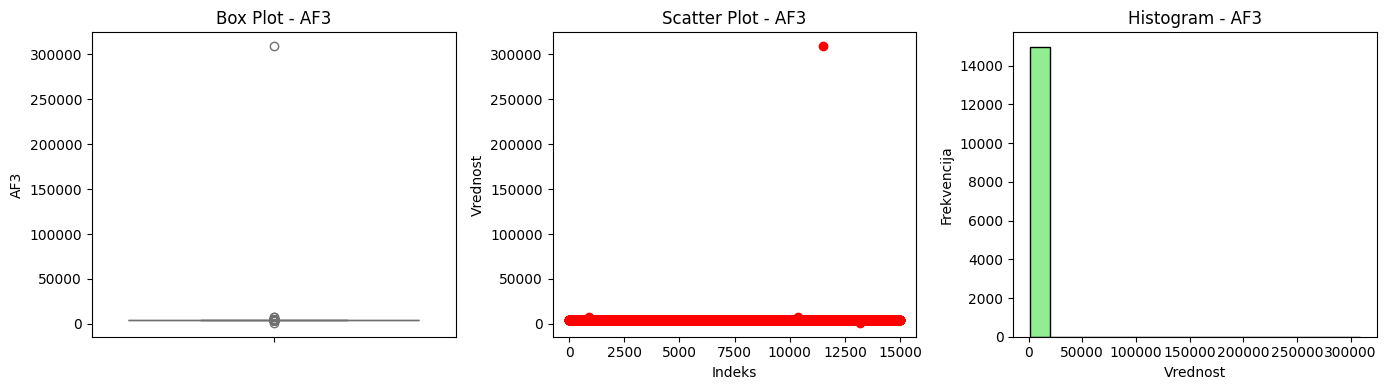

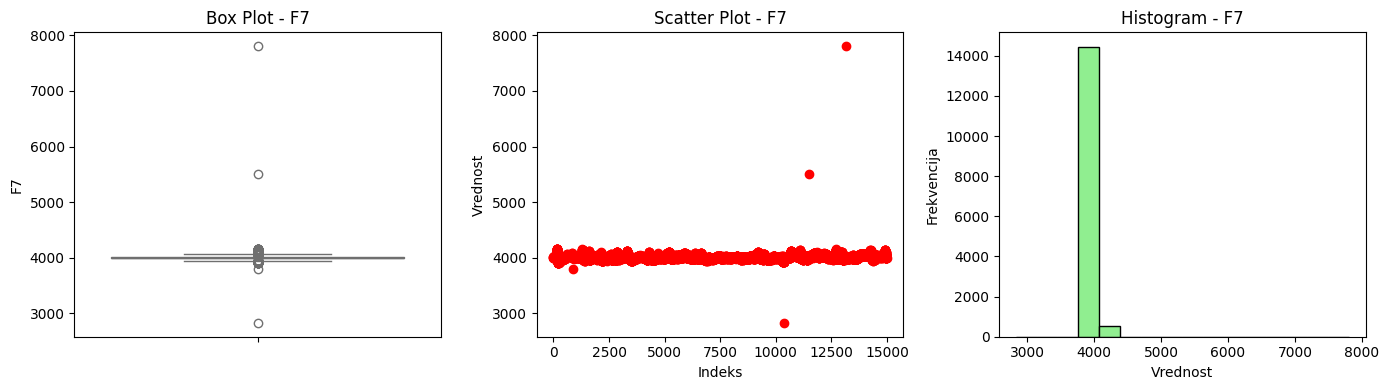

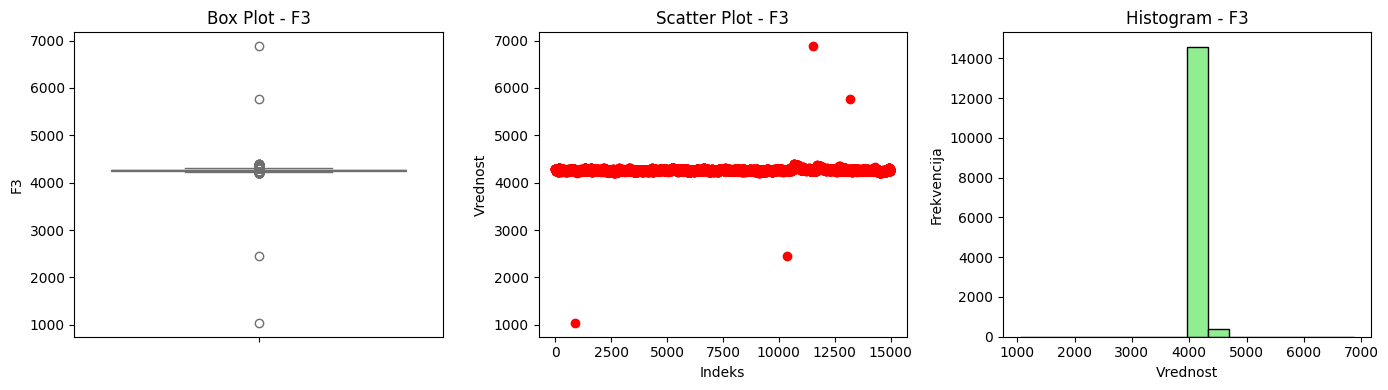

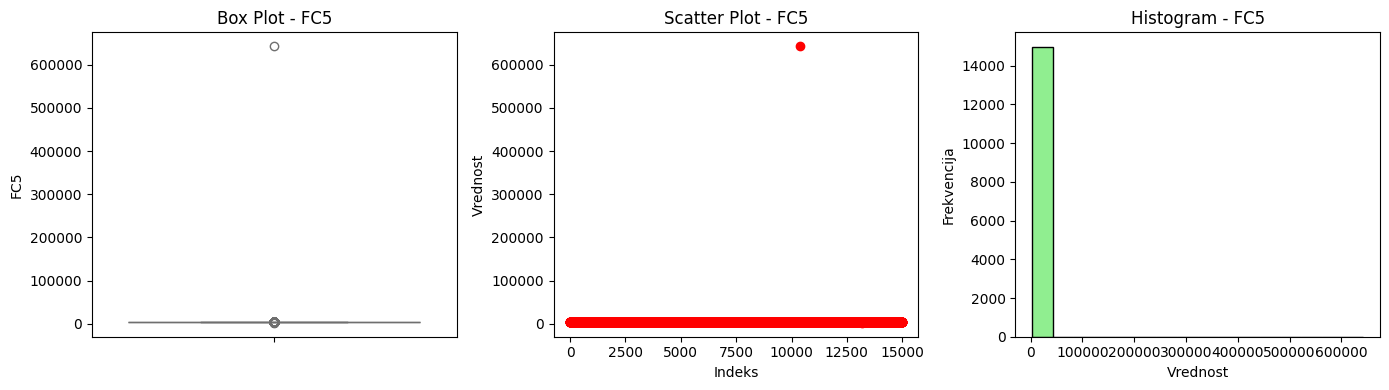

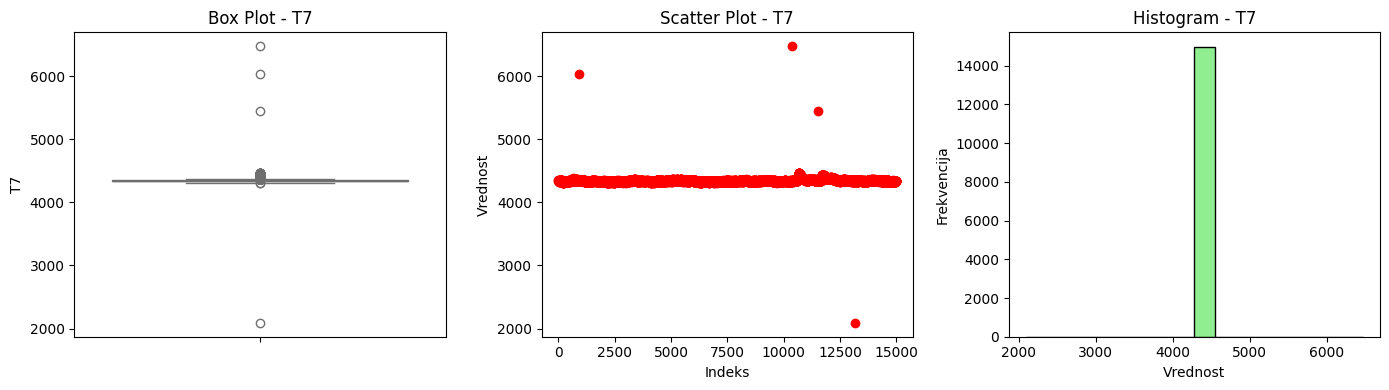

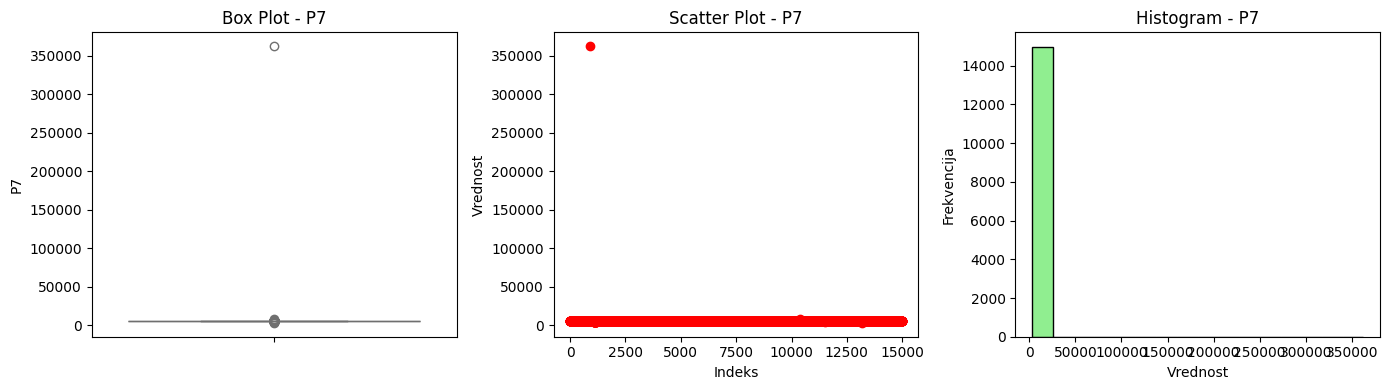

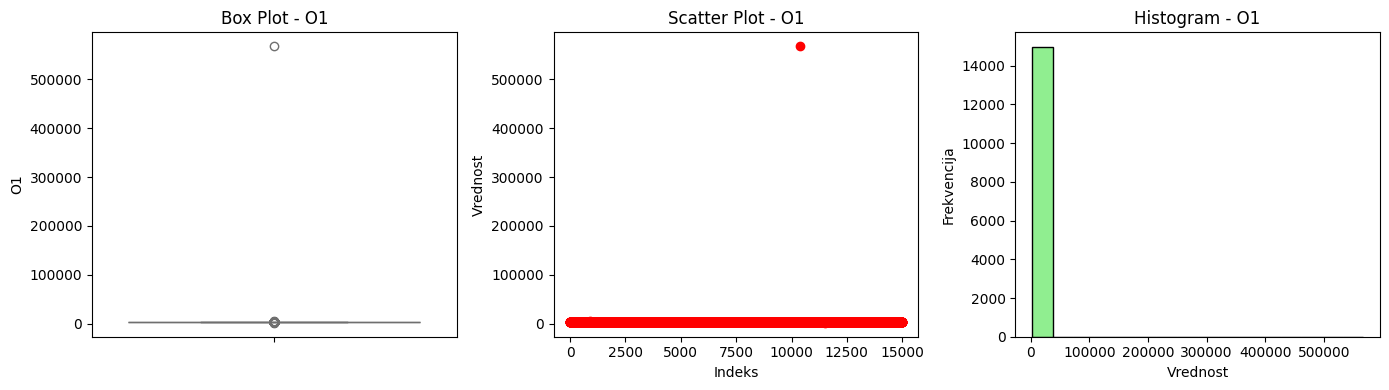

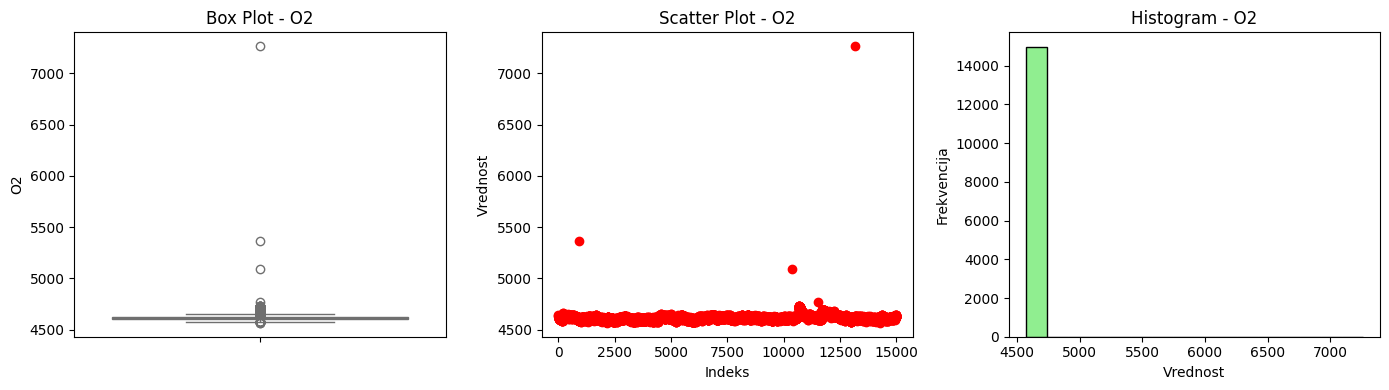

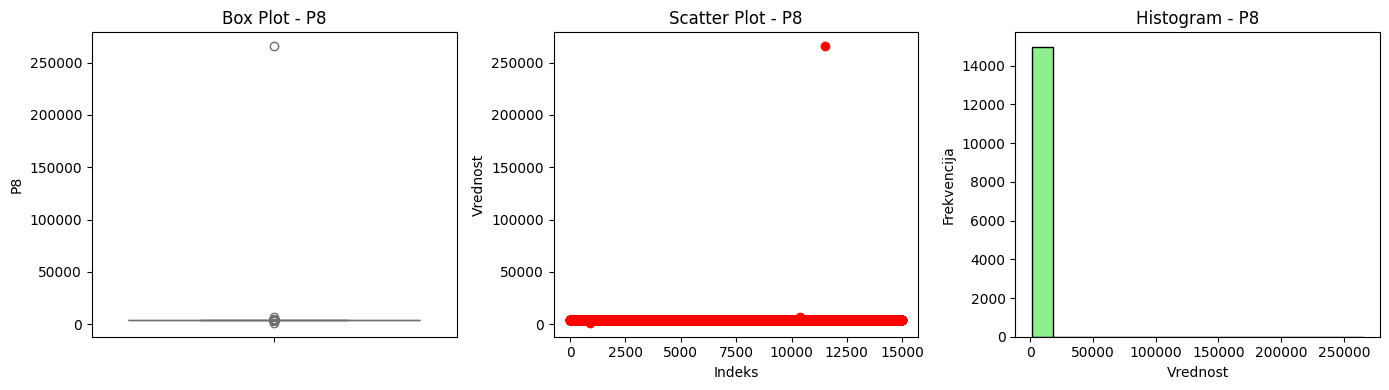

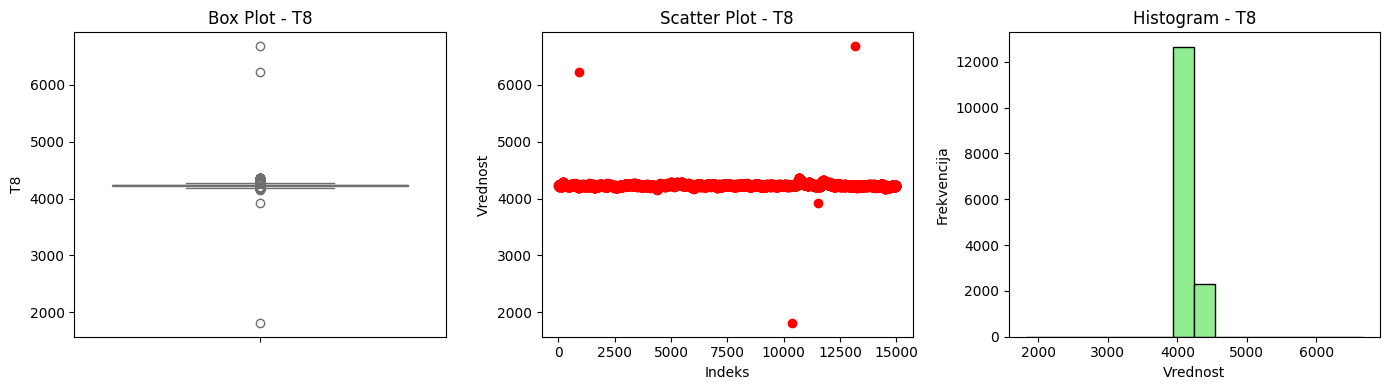

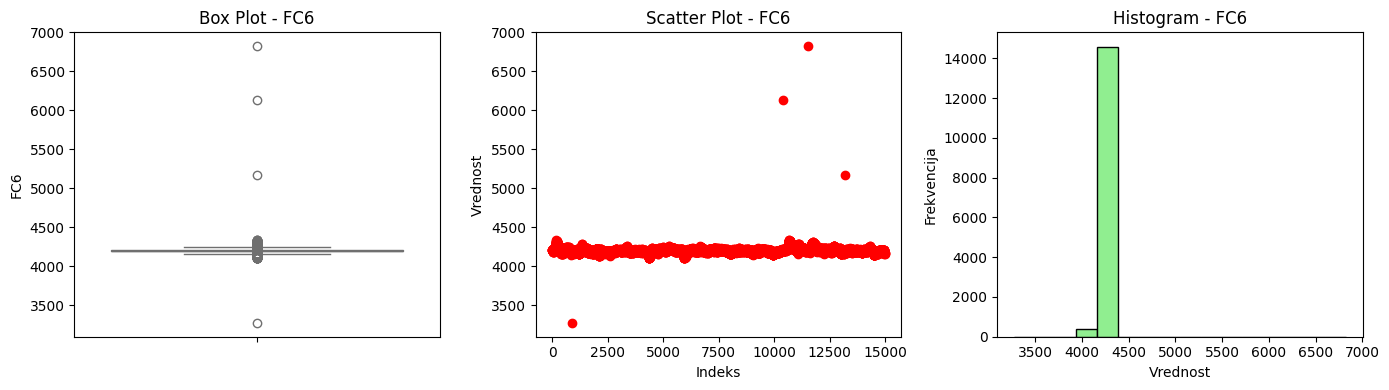

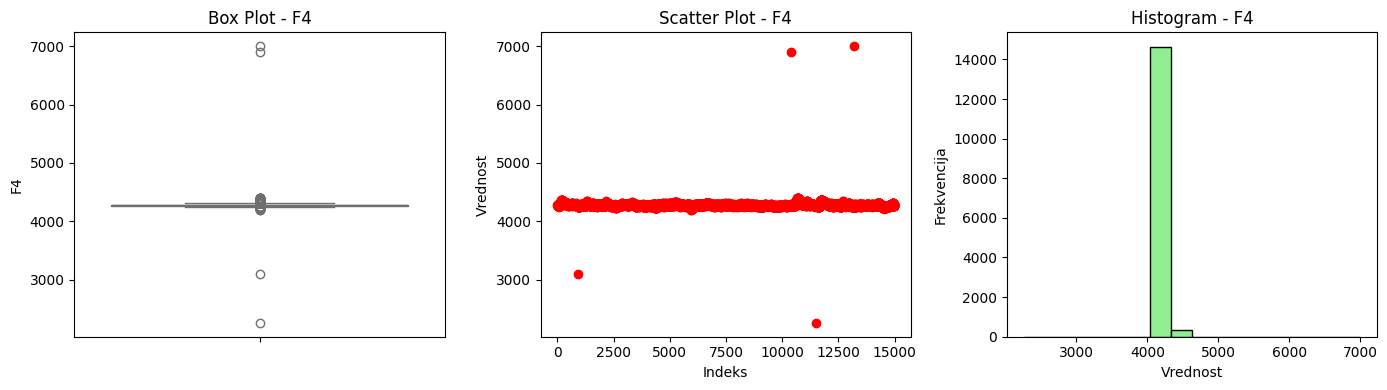

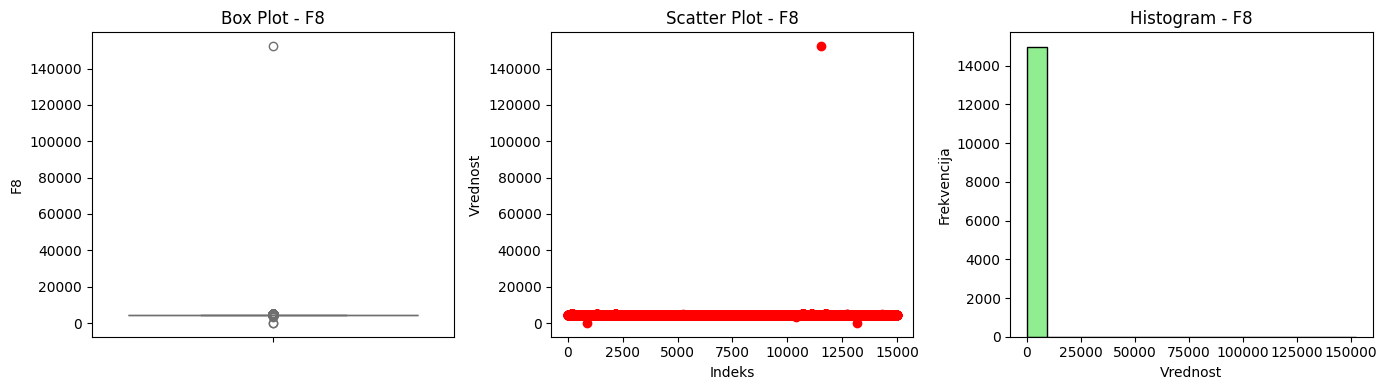

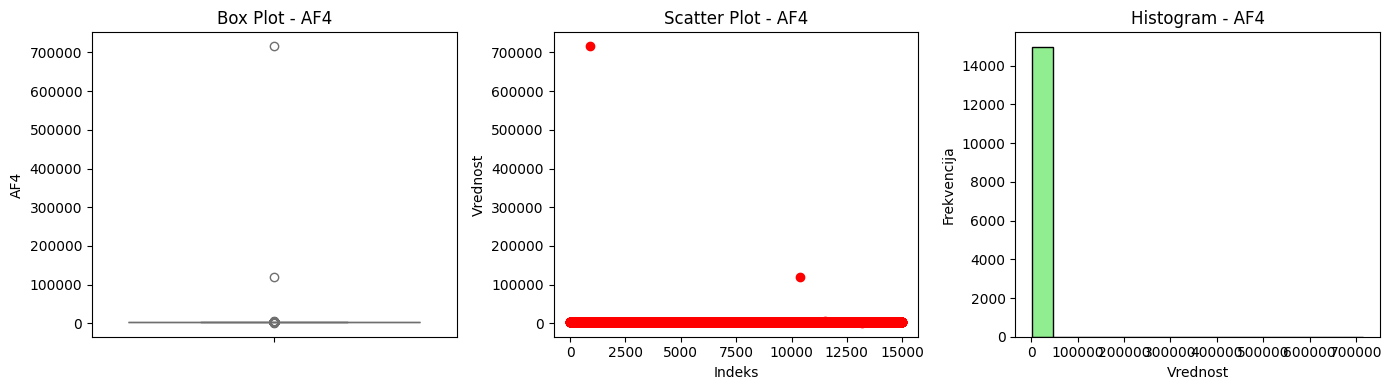

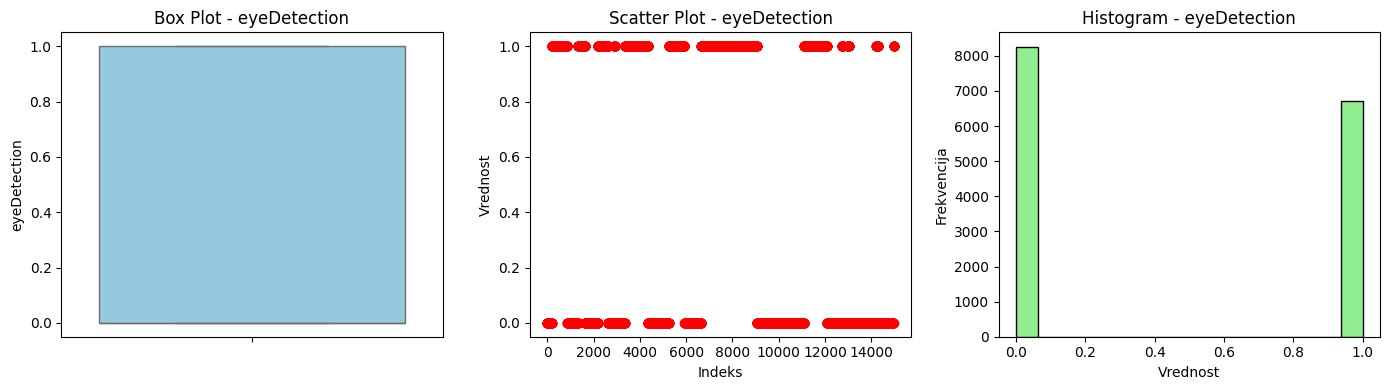

In [228]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [6]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [7]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 4. Treniranje modela

### Podela podataka:

In [8]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11984, 14)
(2996, 14)
(11984,)
(2996,)


### Lazy Predict

In [232]:
# from lazypredict.Supervised import LazyClassifier

# clf = LazyClassifier(
#     verbose=0, 
#     ignore_warnings=True, 
#     custom_metric=None, 
#     predictions=False,
# )

# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

Funkcija za izveštaj o performansama modela:

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np


def report(y_test=None, y_pred=None, title=None, estimator=None, X=None, y=None, cv=5):

    if estimator is not None and X is not None and y is not None:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        y_true_all = []
        y_pred_all = []
        # acc_scores = []

        for train_idx, test_idx in skf.split(X, y):
            # podrška i za pandas i za numpy
            if hasattr(X, "iloc"):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            else:
                X_train, X_test = X[train_idx], X[test_idx]

            if hasattr(y, "iloc"):
                y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
            else:
                y_train, y_test_fold = y[train_idx], y[test_idx]

            estimator.fit(X_train, y_train)
            y_pred_fold = estimator.predict(X_test)

            # acc_scores.append(accuracy_score(y_test_fold, y_pred_fold))
            y_true_all.extend(list(y_test_fold))
            y_pred_all.extend(list(y_pred_fold))
            
        accuracy = accuracy_score(y_true_all, y_pred_all)

        return {
            "title": title,
            "accuracy": float(accuracy),
            "classification_report": classification_report(y_true_all, y_pred_all, output_dict=True),
            "confusion_matrix": confusion_matrix(y_true_all, y_pred_all)
        }

    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "title": title,
        "accuracy": acc,
        "classification_report": cr,
        "confusion_matrix": cm
    }


### Random Forest

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.pipeline import Pipeline

def run_random_forest_classifier(X_train = None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    forest = RandomForestClassifier(random_state=42, n_jobs=1)
    
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", forest))

    pipe = Pipeline(steps)
        
    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="Random Forest CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test=y_test, y_pred=y_pred, title="Random Forest")
        

    return res["accuracy"]

### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [11]:
from sklearn.ensemble import ExtraTreesClassifier


def run_extra_trees_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", et_classifier))

    pipe = Pipeline(steps)
    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="Extra Trees Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "Extra Trees Classifier")
        
    return res["accuracy"]        

### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", KNeighborsClassifier()))

    pipe = Pipeline(steps)  

    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="K-Nearest Neighbour Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "K-Nearest Neighbour Classifier")
        
    return res["accuracy"]

### SVM

In [13]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)))

    pipe = Pipeline(steps)

    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="SVM Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "SVM Classifier")
        
    return res["accuracy"]

### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def run_logistic_regression_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = LogisticRegression(
        n_jobs = 1, max_iter=1000, random_state=42
    )

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", clf))

    pipe = Pipeline(steps)

    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="Logistic Regression Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "Logistic Regression Classifier")
    return res["accuracy"]
    

### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

def run_naive_bayes_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", GaussianNB()))

    pipe = Pipeline(steps)

    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="Naive Bayes Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "Naive Bayes Classifier")
        
    return res["accuracy"]

### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [16]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(X_train=None, y_train=None, X_test=None, y_test=None, preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = DecisionTreeClassifier(random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", clf))

    pipe = Pipeline(steps)
    if cv is not None and X is not None and y is not None:
        res = report(estimator=pipe, X=X, y=y, title="Decision Tree Classifier CV", cv=cv)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        res = report(y_test, y_pred, "Decision Tree Classifier")
        
    return res["accuracy"]

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

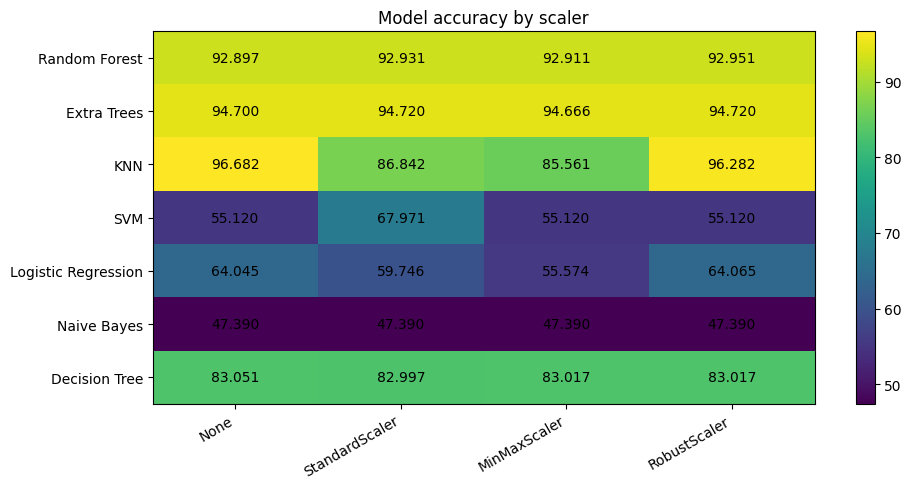

In [ ]:
def run_classifiers_matrix(X_train = None, y_train=None, X_test=None, y_test=None, X=None, y=None, scalers_dict=None, cv=None, sampler=None):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X_train, y_train, X_test, y_test, X=X, y=y, preprocessors=preprocessors,sampler=sampler, cv=cv) * 100
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],   
    "RobustScaler": [RobustScaler()],
}

acc_matrix1 = run_classifiers_matrix(
    X=X, y=y,  
    scalers_dict=scalers,
    cv=5    
)
plot_matrix_heatmap(acc_matrix1, title="Model accuracy by scaler")


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

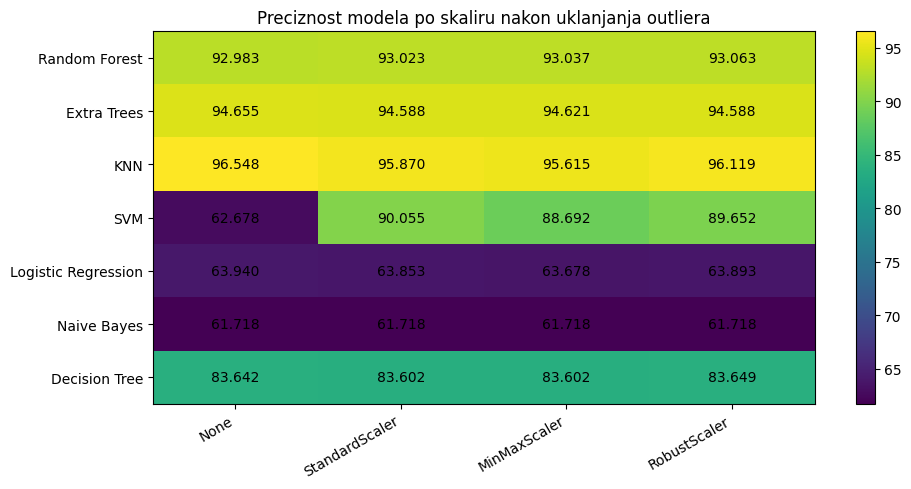

In [18]:
df_no_outliers = df[~zscore_mask]

y_no_outliers = df_no_outliers['eyeDetection']

X_no_outliers = df_no_outliers.drop(
    ['eyeDetection'],
    axis=1
)

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix2 = run_classifiers_matrix(X=X_no_outliers, y=y_no_outliers, scalers_dict=scalers, cv=5)
plot_matrix_heatmap(acc_matrix2, title="Preciznost modela po skaliru nakon uklanjanja outliera")

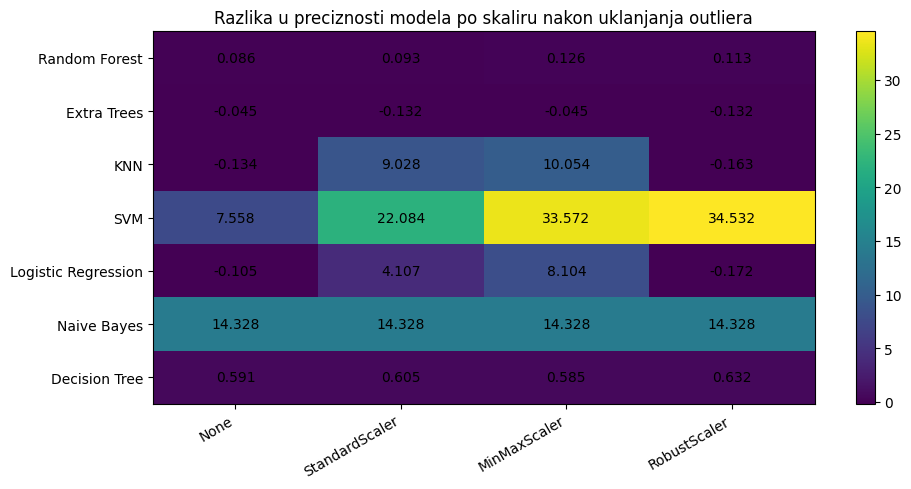

In [19]:
plot_matrix_heatmap(acc_matrix2 - acc_matrix1, title="Razlika u preciznosti modela po skaliru nakon uklanjanja outliera")

Iz matrice se može videti da je uglavnom došlo do poboljšanja preciznosti većine modela. Preciznost kod Decision Tree i KNN je malo opala, ali neuporedivo sa poboljšanjem ostalih.

### Balansiranje

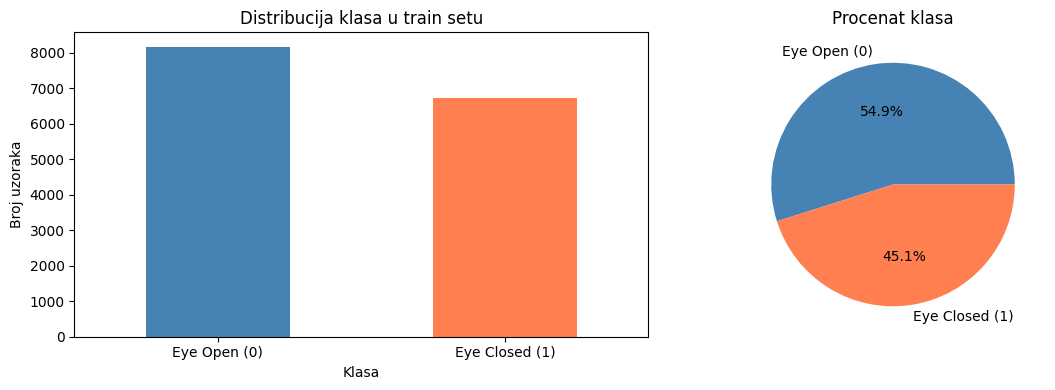

Imbalance ratio: 1.22:1


In [269]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# # Treba li sad sa ovim train...kako kad se radi cross validation? ovo je moglo da se odradi mozda nad celim datasetom
# y_train_no_outliers.value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
# ax[0].set_title('Distribucija klasa u train setu')
# ax[0].set_xlabel('Klasa')
# ax[0].set_ylabel('Broj uzoraka')
# ax[0].set_xticklabels(['Eye Open (0)', 'Eye Closed (1)'], rotation=0)

# y_train_no_outliers.value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
#                                          labels=['Eye Open (0)', 'Eye Closed (1)'],
#                                          colors=['steelblue', 'coral'])
# ax[1].set_title('Procenat klasa')
# ax[1].set_ylabel('')

# plt.tight_layout()
# plt.show()

# imbalance_ratio = y_train_no_outliers.value_counts().max() / y_train_no_outliers.value_counts().min()
# print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Treba li sad sa ovim train...kako kad se radi cross validation? ovo je moglo da se odradi mozda nad celim datasetom
y_no_outliers.value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
ax[0].set_title('Distribucija klasa u train setu')
ax[0].set_xlabel('Klasa')
ax[0].set_ylabel('Broj uzoraka')
ax[0].set_xticklabels(['Eye Open (0)', 'Eye Closed (1)'], rotation=0)

y_no_outliers.value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         labels=['Eye Open (0)', 'Eye Closed (1)'],
                                         colors=['steelblue', 'coral'])
ax[1].set_title('Procenat klasa')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

imbalance_ratio = y_no_outliers.value_counts().max() / y_no_outliers.value_counts().min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

#### Metode balansiranja

1. **Random Oversampling** - duplikacija manjinske klase
2. **Random Undersampling** - smanjenje većinske klase
3. **SMOTE** - generisanje sintetičkih uzoraka manjinske klase
4. **ADASYN** - adaptivno generisanje sintetičkih uzoraka
5. **SMOTETomek** - kombinacija SMOTE i Tomek links
6. **SMOTEENN** - kombinacija SMOTE i Edited Nearest Neighbours

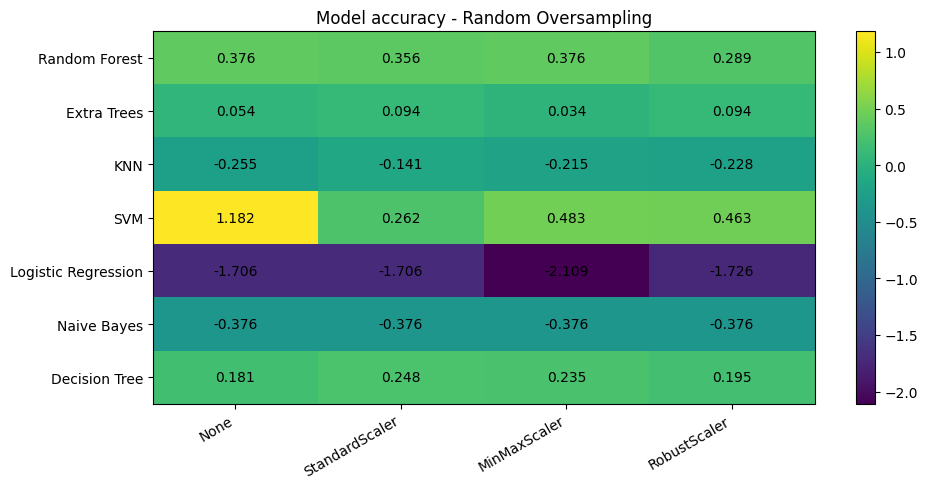

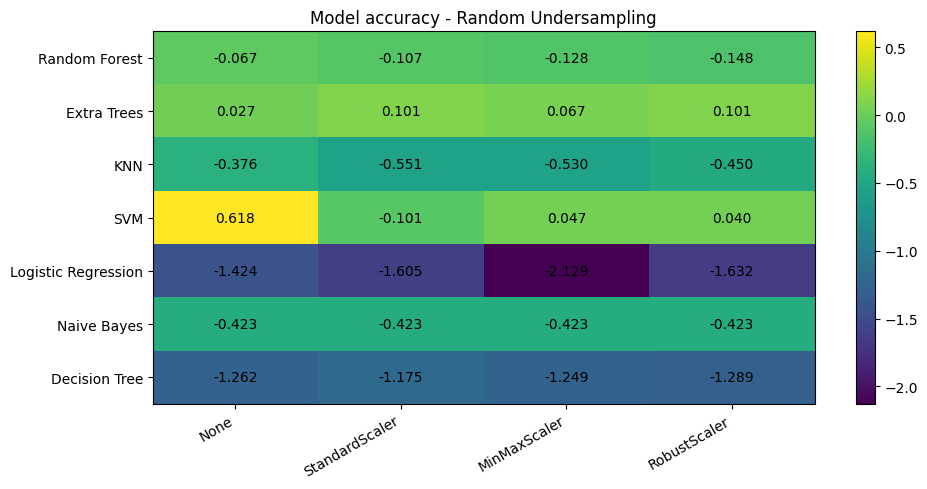

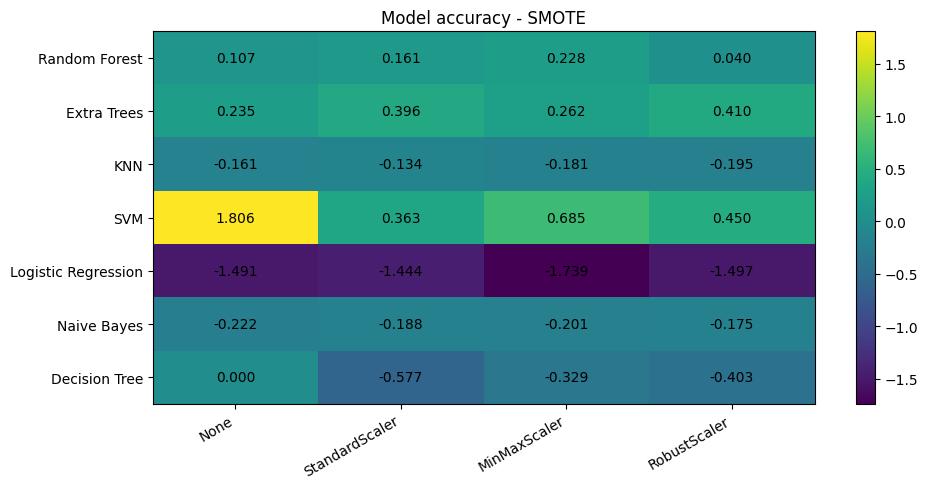

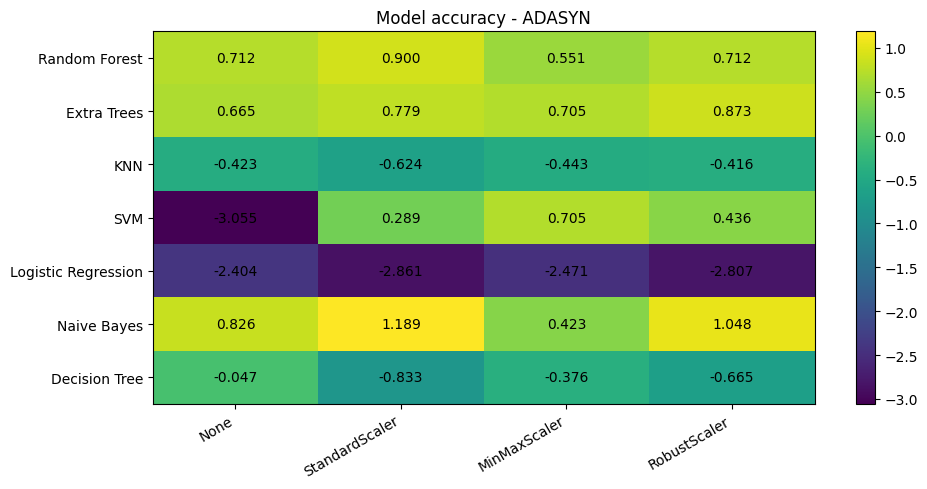

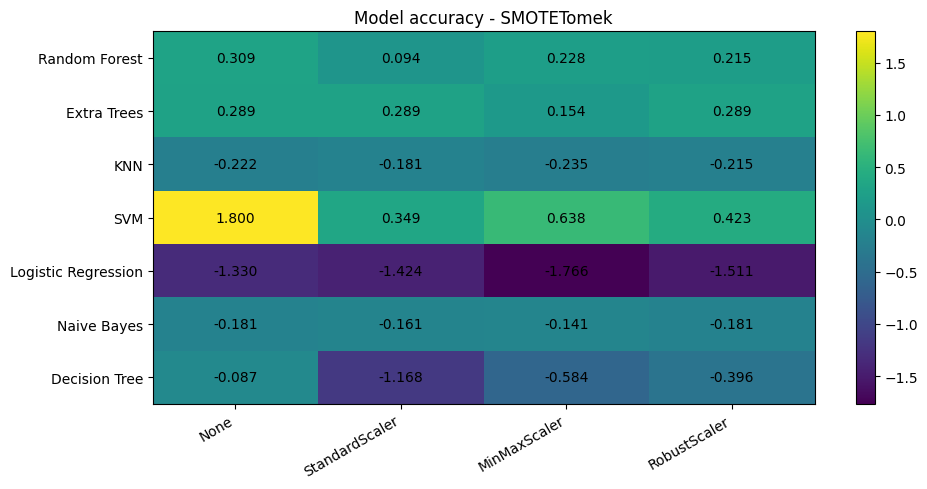

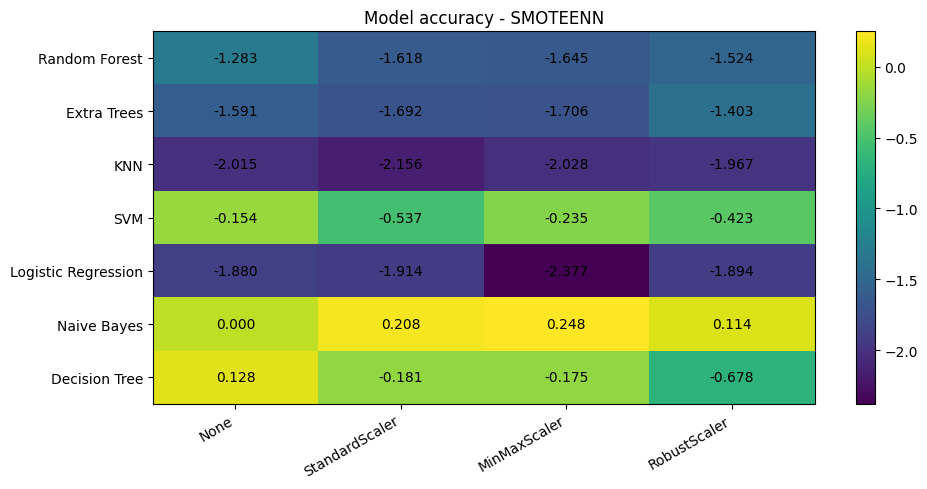

In [270]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

def evaluate_balancing_methods( X_train=None, y_train=None, X_test=None, y_test=None,
    X=None, y=None, cv=None):
    balancing_methods = {
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }
    
    results = []
    balanced_datasets = {}
    
    for method_name, sampler in balancing_methods.items():
        if cv is None:
            if sampler is None:
                X_bal, y_bal = X_train, y_train
            else:
                X_bal, y_bal = sampler.fit_resample(X_train, y_train)
                
            balanced_datasets[method_name] = (X_bal, y_bal)
            
            res = run_classifiers_matrix(X_bal, y_bal, X_test, y_test, scalers_dict=scalers, cv=None) - acc_matrix2
        else:
            balanced_datasets[method_name] = (X, y)
            
            res = run_classifiers_matrix(
                X=X,
                y=y,
                scalers_dict=scalers,
                sampler=sampler,  # sampler ide u pipeline
                cv=cv
            ) - acc_matrix2
            
            
        plot_matrix_heatmap(res, title="Model accuracy - " + method_name)
        results.append({
            "Balancing Method": method_name,
            "Accuracy Matrix": res
        })
    
    return pd.DataFrame(results), balanced_datasets

balancing_results, balanced_datasets = evaluate_balancing_methods(
        X=X_no_outliers,
    y=y_no_outliers,
    cv=5  # broj fold-ova
)


#### Analiza najbolje metode balansiranja

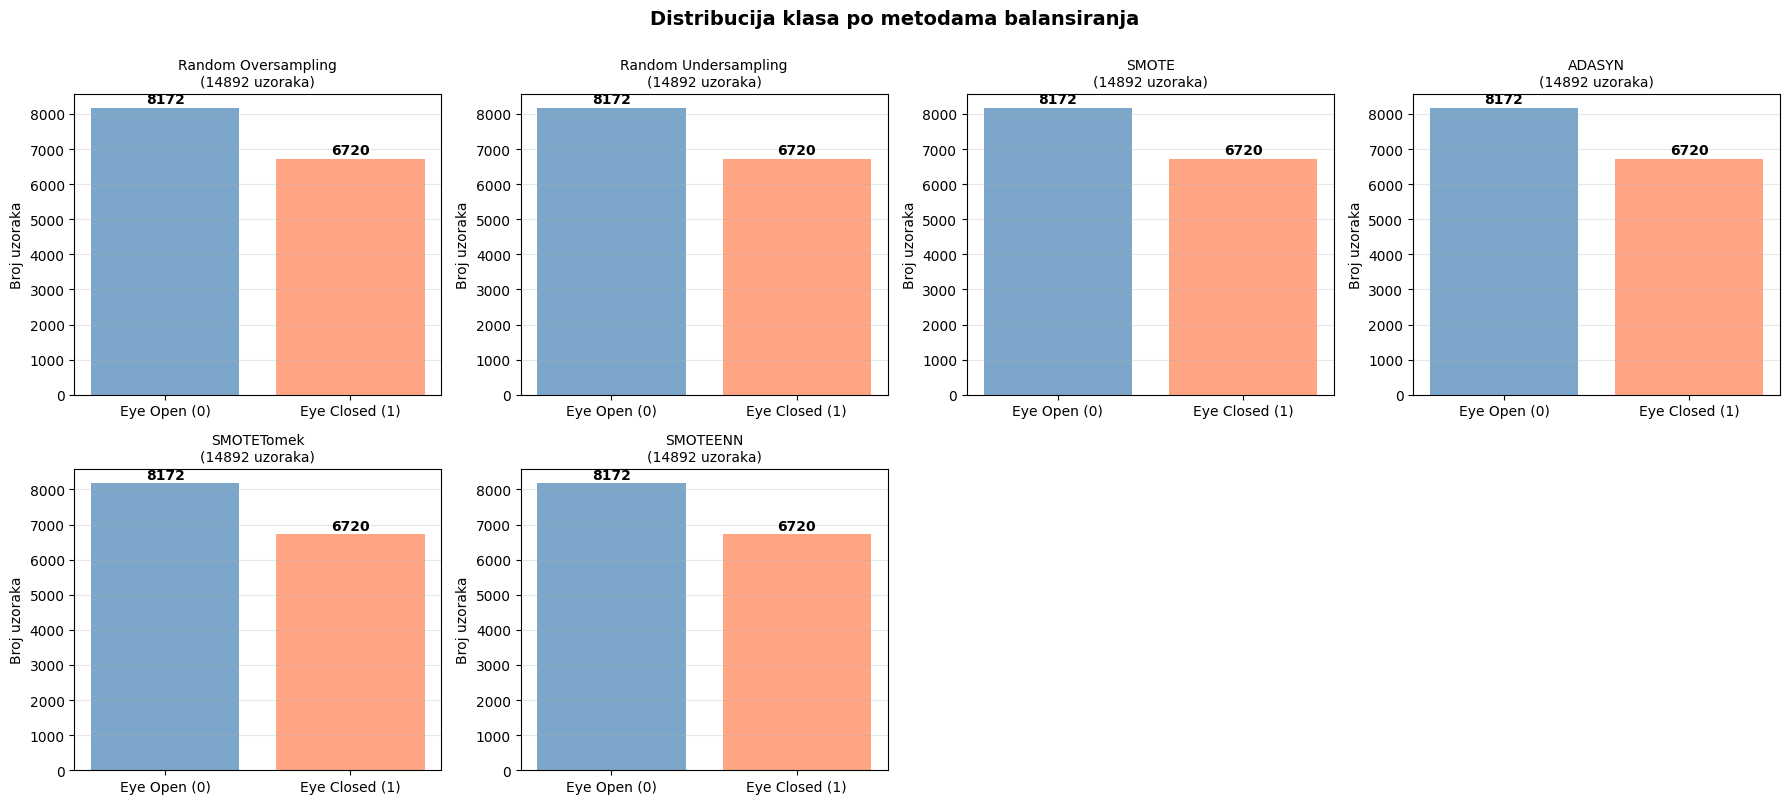

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()
#  Kod cross-validacije balansiranje se radi UNUTAR svakog training fold-a, a NIKADA nad celim datasetom unapred. tkd ovaj fdeo dole nista ne radi za cross-validation, ali kada je bez radi
for idx, (method_name, (X_bal, y_bal)) in enumerate(balanced_datasets.items()):
    if idx < len(axes):
        counts = pd.Series(y_bal).value_counts().sort_index()
        axes[idx].bar(['Eye Open (0)', 'Eye Closed (1)'], counts.values, 
                     color=['steelblue', 'coral'], alpha=0.7)
        axes[idx].set_title(f'{method_name}\n({counts.sum()} uzoraka)', fontsize=10)
        axes[idx].set_ylabel('Broj uzoraka')
        axes[idx].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(counts.values):
            axes[idx].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

for idx in range(len(balanced_datasets), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribucija klasa po metodama balansiranja', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

### 5.1 Definicija funkcija za evaluaciju

In [20]:
def evaluate_all_models(X_train, X_test, y_train, y_test, step_name=""):
    models = {
        "Random Forest": RandomForestClassifier(random_state=42, n_jobs=1),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=1),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
    }
    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            "Model": name,
            "Accuracy (%)": round(acc * 100, 2),
            "F1-Score (%)": round(f1 * 100, 2),
            "Step": step_name
        })
    
    return pd.DataFrame(results)
# Mislim da nam evalueate_all_models vise ne treba, ali ajde da ostane za svaki slucaj
def plot_comparison(results_df, title="Poređenje modela"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['Accuracy (%)'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, results_df['F1-Score (%)'], width, label='F1-Score', color='coral')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Score (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 100)
    
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

### Uklanjanje visoko korelisanih feature-a

Na osnovu ranije analize korelacije, uklanjamo redundantne feature-e koji imaju korelaciju > 0.95.

In [24]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

def get_high_corr_pairs(df: pd.DataFrame, threshold: float = 0.9):
    corr = df.corr().abs()
    cols = list(corr.columns)

    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            v = corr.iloc[i, j]
            if v > threshold:
                pairs.append((cols[i], cols[j], float(v)))
    return pairs

def evaluate_hight_corr_drops2(X, y, pairs, max_drop=5):
    all_corr_cols = set()
    for col_a, col_b, _ in pairs:
        all_corr_cols.add(col_a)
        all_corr_cols.add(col_b)
    
    all_corr_cols = list(all_corr_cols)
    
    results = []
    
    for num_to_drop in range(1, min(max_drop + 1, len(all_corr_cols) + 1)):
        combinations = itertools.combinations(all_corr_cols, num_to_drop)
        
        for drop_set in combinations:
            drop_set = list(drop_set)
            X_reduced = X.drop(columns=drop_set)




            matrix = run_classifiers_matrix( X=X_reduced,y=y,scalers_dict=scalers,cv=5)
            best_acc = matrix.max().max()
            best_model, best_scaler = matrix.stack().idxmax()
# vidi mozda svuda da se izbaci kad nije cross val... vidi sa lukom..mnogo dodatnog koda za d
            results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Best Classifier": best_model,
                "Accuracy (%)": best_acc,
                "Remaining Features": X_reduced.shape[1],
                "Best Scaler": best_scaler,
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="Accuracy (%)", ascending=False)
    
    return results_df


# print(evaluate_all_models(X_train,X_test, y_train, y_test, ''))
# pairs = get_high_corr_pairs(X, threshold=0.95)
# drop2_results = evaluate_hight_corr_drops2(X, y, pairs, max_drop=5)
# print(f"Ukupno varijanti: {len(drop2_results)}")
# print("\nTop 10 najboljih kombinacija:")
# print(drop2_results.head(10).to_string(index=False))


# print(evaluate_all_models(X_train_no_outliers,X_test_no_outliers, y_train_no_outliers, y_test_no_outliers, ''))
# pairs2 = get_high_corr_pairs(X_no_outliers, threshold=0.9)
# drop2_results2 = evaluate_hight_corr_drops2(X_no_outliers, y_no_outliers, pairs2, max_drop=5)
# print(f"Ukupno varijanti: {len(drop2_results2)}")
# print("\nTop 10 najboljih kombinacija bez outlier-a:")
# print(drop2_results2.head(10).to_string(index=False))


# Prikaz osnovne matrice model × scaler
base_matrix = run_classifiers_matrix(
    X=X,
    y=y,
    scalers_dict=scalers,
    cv=5
)

print("Osnovna accuracy matrica:")
print(base_matrix)

# Pronalaženje visoko korelisanih parova
pairs = get_high_corr_pairs(X, threshold=0.95)

# Feature selection eksperimenti
drop2_results = evaluate_hight_corr_drops2(X, y, pairs, max_drop=5)

print(f"\nUkupno varijanti: {len(drop2_results)}")
print("\nTop 10 najboljih kombinacija:")
print(drop2_results.head(10).to_string(index=False))



# Osnovna matrica za podatke bez outlier-a
base_matrix_no_out = run_classifiers_matrix(
    X=X_no_outliers,
    y=y_no_outliers,
    scalers_dict=scalers,
    cv=2
)

print("Osnovna accuracy matrica (bez outlier-a):")
print(base_matrix_no_out)

# Pronalaženje visoko korelisanih parova
pairs2 = get_high_corr_pairs(X_no_outliers, threshold=0.9)

# Feature selection eksperimenti
drop2_results2 = evaluate_hight_corr_drops2(
    X_no_outliers,
    y_no_outliers,
    pairs2,
    max_drop=5
)

print(f"\nUkupno varijanti: {len(drop2_results2)}")
print("\nTop 10 najboljih kombinacija bez outlier-a:")
print(drop2_results2.head(10).to_string(index=False))






c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

Osnovna accuracy matrica:
                          None  StandardScaler  MinMaxScaler  RobustScaler
Random Forest        92.897196       92.930574     92.910547     92.950601
Extra Trees          94.699599       94.719626     94.666222     94.719626
KNN                  96.682243       86.842457     85.560748     96.281709
SVM                  55.120160       67.970628     55.120160     55.120160
Logistic Regression  64.138852       59.746328     55.574099     64.065421
Naive Bayes          47.389853       47.389853     47.389853     47.389853
Decision Tree        83.050734       82.997330     83.017356     83.017356


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

KeyboardInterrupt: 

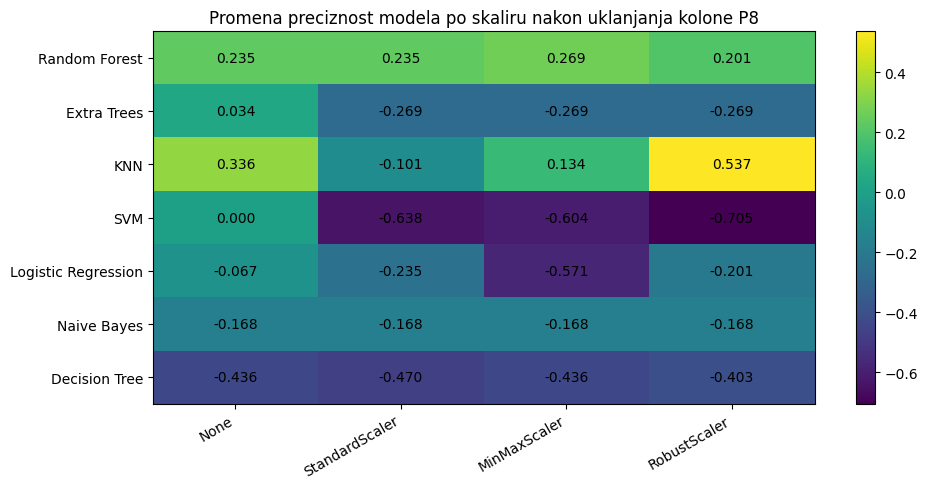

In [149]:
X_train_no_P8 = X_train_no_outliers.drop(columns=['P8'])
X_test_no_P8 = X_test_no_outliers.drop(columns=['P8'])

y_train_no_P8 = y_train_no_outliers
y_test_no_P8 = y_test_no_outliers

acc_matrix3 = run_classifiers_matrix(X_train_no_P8, y_train_no_P8, X_test_no_P8, y_test_no_P8, scalers)
plot_matrix_heatmap(acc_matrix3 - acc_matrix2, title="Promena preciznost modela po skaliru nakon uklanjanja kolone P8")

### Redukcija dimenzionalnosti (PCA)

Primenjujemo PCA (Principal Component Analysis) za redukciju dimenzionalnosti sa zadržavanjem 95% varijanse.

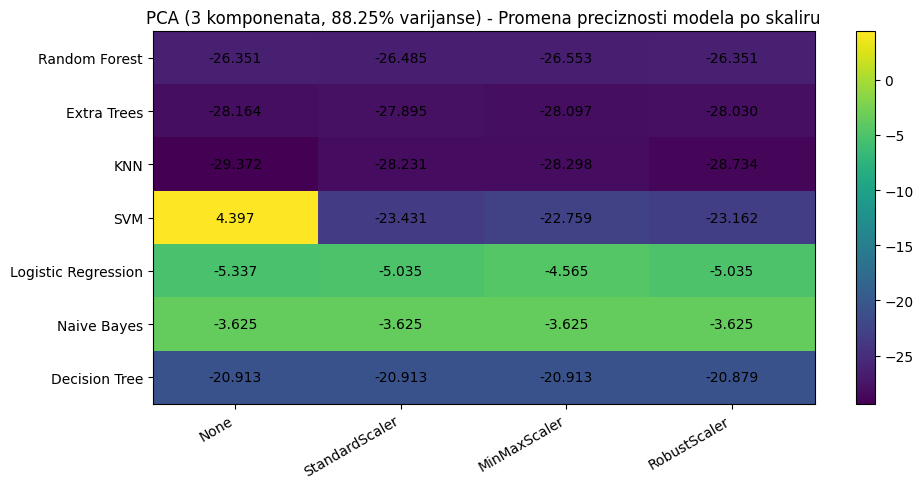

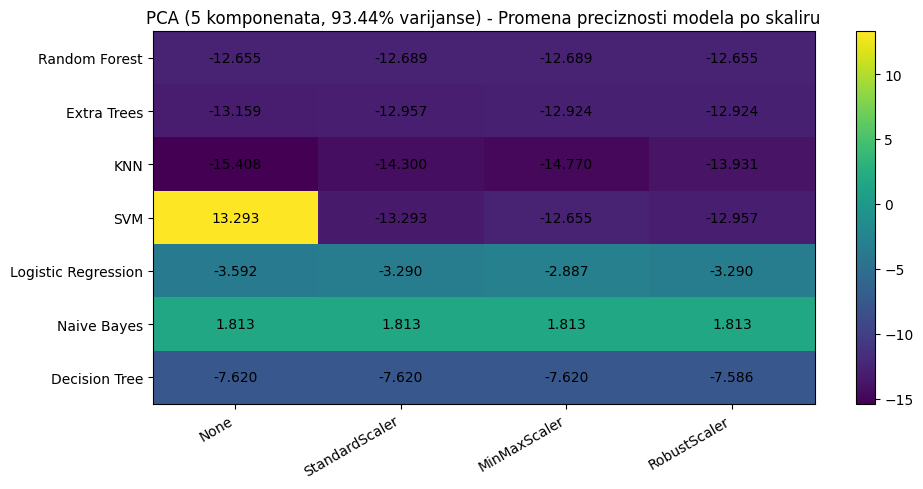

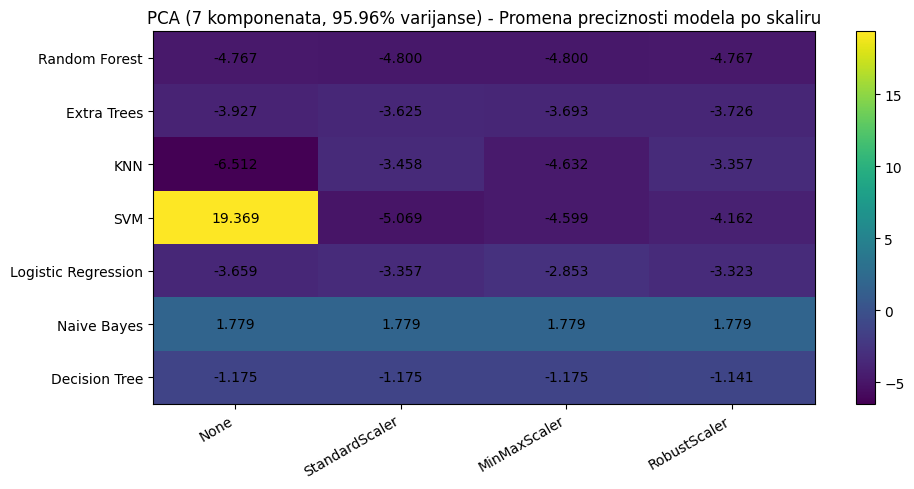

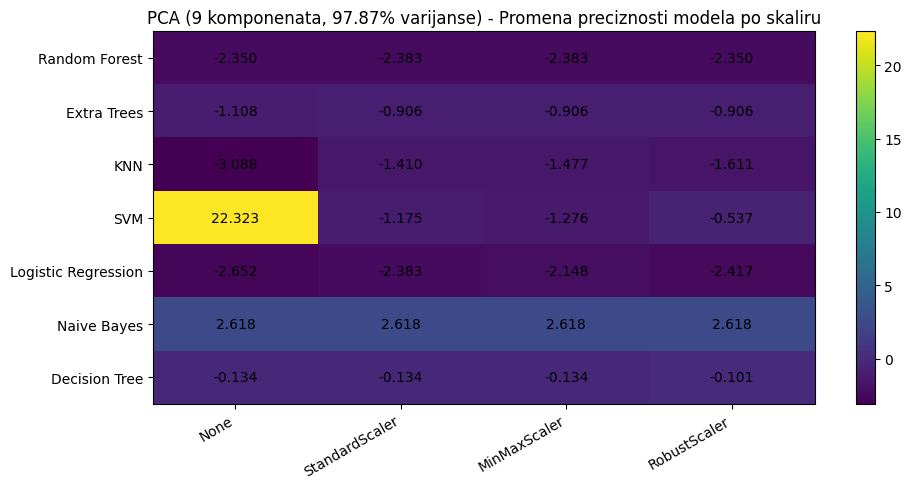

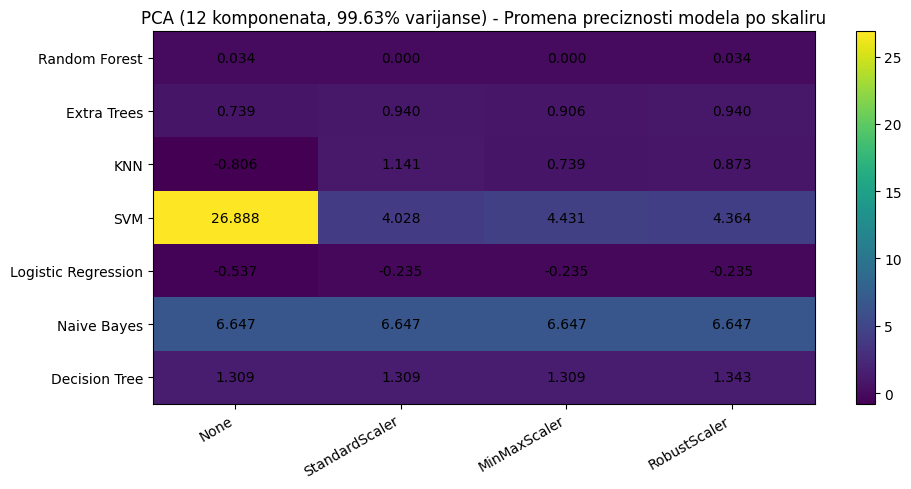

In [ ]:
pca_results = []

for n_components in [3, 5, 7, 9, 12]:
    pca = PCA(n_components=n_components)

    scalers_with_pca = {
        scaler_name: (preprocessors + [PCA(n_components=n_components, random_state=42)])
        for scaler_name, preprocessors in scalers.items()
    }

    res = run_classifiers_matrix(X=X_no_outliers, y=y_no_outliers, scalers_dict=scalers_with_pca, cv=5)
#  ja bi isla samo bez outliera sad ovde
    plot_matrix_heatmap(res - run_classifiers_matrix(X=X_no_outliers, y=y_no_outliers, scalers_dict=scalers, cv=5), title=f"PCA ({n_components} komponenata - Promena preciznosti modela po skalaru")

    pca_results.append({
        "n_components": n_components,
        "accuracy": res
    })

### Optimizacija hiperparametara

In [151]:
print("\n--- Random Forest optimizacija ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=1)
rf_grid = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=1, verbose=1)
rf_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {rf_grid.best_params_}")
print(f"Najbolja CV tačnost: {rf_grid.best_score_*100:.2f}%")

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, rf_pred)*100:.2f}%")


--- Random Forest optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najbolji parametri: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Najbolja CV tačnost: 92.50%
Test tačnost: 93.96%


In [152]:
# Extra Trees optimizacija
print("\n--- Extra Trees optimizacija ---")
et_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

et = ExtraTreesClassifier(random_state=42, n_jobs=1)
et_grid = RandomizedSearchCV(et, et_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=1, verbose=1)
et_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {et_grid.best_params_}")
print(f"Najbolja CV tačnost: {et_grid.best_score_*100:.2f}%")

et_best = et_grid.best_estimator_
et_pred = et_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, et_pred)*100:.2f}%")


--- Extra Trees optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Najbolja CV tačnost: 94.38%
Test tačnost: 95.60%


In [153]:
# KNN optimizacija
print("\n--- KNN optimizacija ---")
knn_param_grid = {
    'n_neighbors': range(1, 300, 2) ,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1, random_state=42)
knn_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {knn_grid.best_params_}")
print(f"Najbolja CV tačnost: {knn_grid.best_score_*100:.2f}%")

knn_best = knn_grid.best_estimator_
knn_pred = knn_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, knn_pred)*100:.2f}%")



--- KNN optimizacija ---


TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'random_state'

In [ ]:
# SVM optimizacija
print("\n--- SVM optimizacija ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm = SVC(random_state=42)
svm_grid = RandomizedSearchCV(svm, svm_param_grid, n_iter=15, cv=5, scoring='accuracy', 
                               random_state=42, n_jobs=1, verbose=1)
svm_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {svm_grid.best_params_}")
print(f"Najbolja CV tačnost: {svm_grid.best_score_*100:.2f}%")

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, svm_pred)*100:.2f}%")


--- SVM optimizacija ---


NameError: name 'SVC' is not defined


Rezultati nakon optimizacije hiperparametara
              Model  Accuracy (%)  F1-Score (%)         Step
Random Forest (opt)         93.22         93.21 Optimizovano
  Extra Trees (opt)         94.86         94.85 Optimizovano
          KNN (opt)         91.22         91.21 Optimizovano
          SVM (opt)         83.44         83.27 Optimizovano


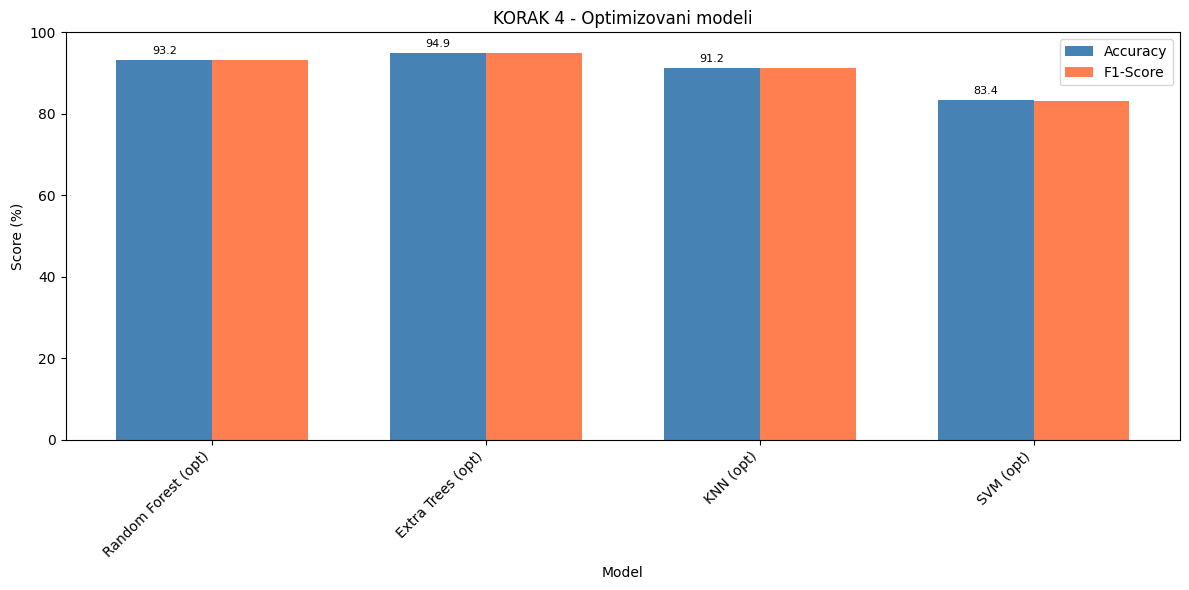

In [ ]:
# Sumarni rezultati nakon optimizacije hiperparametara
print("\n" + "=" * 60)
print("Rezultati nakon optimizacije hiperparametara")
print("=" * 60)

optimized_results = pd.DataFrame([
    {"Model": "Random Forest (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, rf_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, rf_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "Extra Trees (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, et_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, et_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "KNN (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, knn_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, knn_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "SVM (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, svm_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, svm_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
])

print(optimized_results.to_string(index=False))
plot_comparison(optimized_results, "KORAK 4 - Optimizovani modeli")

all_results.append(optimized_results.copy())

## 6. Analiza interpretabilnosti modela

U ovom delu analiziramo interpretabilnost modela koristeći:
- **Feature Importance** - značaj feature-a u tree-based modelima
- **SHAP vrednosti** - SHapley Additive exPlanations
- **LIME** - Local Interpretable Model-agnostic Explanations

### 6.1 Feature Importance (Random Forest & Extra Trees)

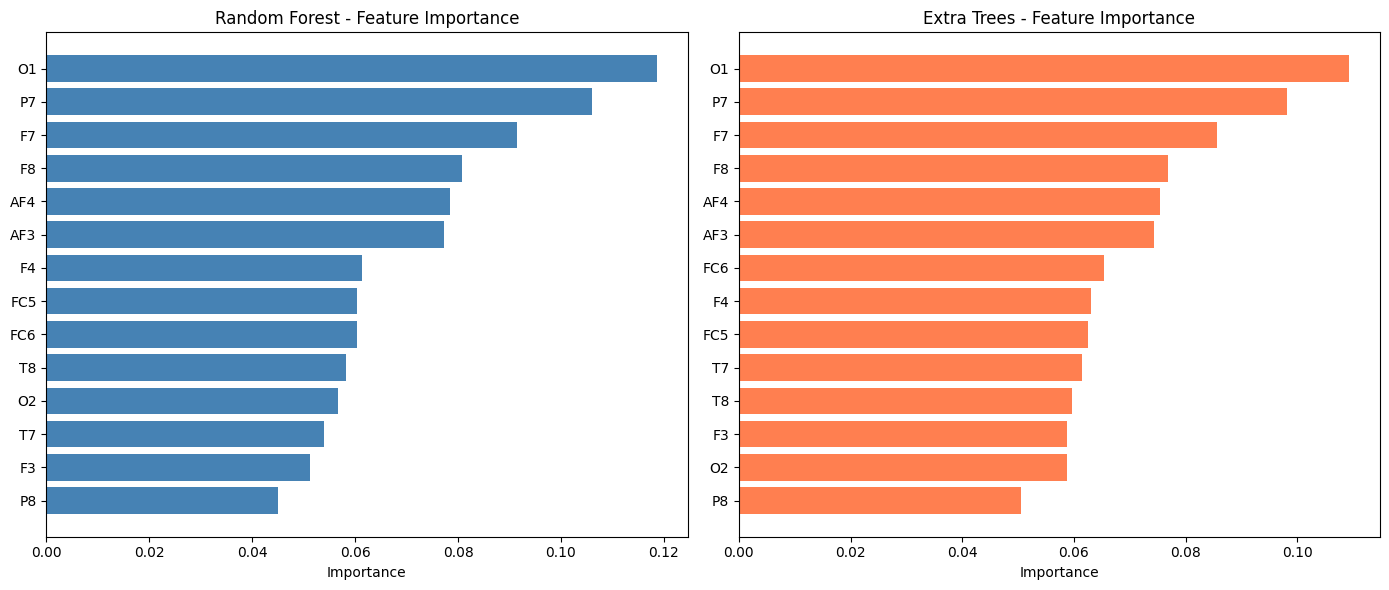


Top 5 najvažnijih feature-a (Random Forest):
Feature  Importance
     O1    0.118659
     P7    0.106063
     F7    0.091444
     F8    0.080860
    AF4    0.078503

Top 5 najvažnijih feature-a (Extra Trees):
Feature  Importance
     O1    0.109358
     P7    0.098150
     F7    0.085555
     F8    0.076801
    AF4    0.075481


In [ ]:
# Feature Importance analiza
feature_names = X.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Extra Trees Feature Importance
et_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].invert_yaxis()

# Extra Trees
axes[1].barh(et_importance['Feature'], et_importance['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Extra Trees - Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 najvažnijih feature-a (Random Forest):")
print(rf_importance.head().to_string(index=False))
print("\nTop 5 najvažnijih feature-a (Extra Trees):")
print(et_importance.head().to_string(index=False))

### SHAP Analiza (SHapley Additive exPlanations)

SHAP vrednosti pokazuju doprinos svakog feature-a predikciji modela.

### LIME Analiza (Local Interpretable Model-agnostic Explanations)

LIME objašnjava pojedinačne predikcije kreirajući lokalni interpretabilan model.